In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt

# load the qcodes path, until we have this installed as a package
import sys

qcpath = '/Users/alex/qdev/Qcodes'
if qcpath not in sys.path:
    sys.path.append(qcpath)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# make a model - models mimic a communication channel,
# accepting and returning string data, so that they can
# mimic real instruments as closely as possible
#
# This could certainly be built in for simple subclassing
# if we use it a lot
import math

class ModelError(Exception):
    pass

class AModel(object):
    def __init__(self):
        self._gates = [0.0, 0.0, 0.0]
        self._excitation = 0.1

    def _output(self):
        # my super exciting model!
        # make a nice pattern that looks sort of double-dotty
        # with the first two gates controlling the two dots,
        # and the third looking like Vsd
        delta_i = 10
        delta_j = 10
        di = (self._gates[0] + delta_i / 2) % delta_i - delta_i / 2
        dj = (self._gates[1] + delta_j / 2) % delta_j - delta_j / 2
        vsd = math.sqrt(self._gates[2]**2 + self._excitation**2)
        dij = math.sqrt(di**2 + dj**2) - vsd
        g = (vsd**2 + 1) * (1 / (dij**2 + 1) + 0.1 * (math.atan(-dij) + math.pi / 2))
        return g
        
    def write(self, instrument, parameter, value):
        if instrument == 'gates' and parameter[0] == 'c':
            self._gates[int(parameter[1:])] = float(value)
        elif instrument == 'gates' and parameter == 'rst':
            self._gates = [0.0, 0.0, 0.0]
        elif instrument == 'source' and parameter == 'ampl':
            self._excitation = float(value)
        else:
            raise ModelError('unrecognized write {}, {}, {}'.format(
                instrument, parameter, value))

    def ask(self, instrument, parameter):
        gates = self._gates

        if instrument == 'gates' and parameter[0] == 'c':
            v = gates[int(parameter[1:])]
        elif instrument == 'source' and parameter == 'ampl':
            v = self._excitation
        elif instrument == 'meter' and parameter == 'ampl':
            # here's my super complex model output!
            v = self._output() * self._excitation
        else:
            raise ModelError('unrecognized ask {}, {}'.format(
                instrument, parameter))

        return '{:.3f}'.format(v)

In [3]:
# make our mock instruments
# real instruments would subclass IPInstrument or VisaInstrument
# instead of MockInstrument,
# and be instantiated with an address rather than a model
from qcodes.instrument.mock import MockInstrument
from qcodes.utils.validators import Numbers

class MockGates(MockInstrument):
    def __init__(self, name, model):
        super().__init__(name, model=model)

        for i in range(3):
            cmdbase = 'c{}'.format(i)
            self.add_parameter('chan{}'.format(i),
                               get_cmd=cmdbase + '?',
                               set_cmd=cmdbase + ' {:.4f}',
                               parse_function=float,
                               vals=Numbers(-100, 100))

        self.add_function('reset', call_cmd='rst')

class MockSource(MockInstrument):
    def __init__(self, name, model):
        super().__init__(name, model=model)

        # this parameter uses built-in sweeping to change slowly
        self.add_parameter('amplitude',
                           get_cmd='ampl?',
                           set_cmd='ampl {:.4f}',
                           parse_function=float,
                           vals=Numbers(0, 10),
                           sweep_step=0.1,
                           sweep_delay=0.05)

        
class MockMeter(MockInstrument):
    def __init__(self, name, model):
        super().__init__(name, model=model)

        self.add_parameter('amplitude',
                           get_cmd='ampl?',
                           parse_function=float)

In [4]:
# now create this "experiment"
model = AModel()
gates = MockGates('gates', model)
source = MockSource('source', model)
meter = MockMeter('meter', model)

from qcodes.station import Station
station = Station(gates, source, meter)

# could measure any number of things by adding to this list,
# but here we're just measuring one, the meter amplitude
# we can also create multiple measurement sets side-by-side,
# but only one is the default one stored in the station
measurement = station.set_measurement(meter['amplitude'])

# it's nice to have the key parameters be part of the global namespace
# that way they're objects that we can easily set, get, and slice
# this could be simplified to a station method that gathers all parameters
# and adds them all as (disambiguated) globals, printing what it did
# something like:
#   station.gather_parameters(globals())
c0, c1, c2, vsd = gates['chan0'], gates['chan1'], gates['chan2'], source['amplitude']

In [5]:
# we can get the measured quantities right now
measurement.get()

(0.117,)

In [7]:
# start a sweep (which by default runs in a seprarate process)
# the sweep values are defined by slicing the parameter object
# but more complicated sweeps (eg nonlinear, or adaptive) can
# easily be used instead
swp = measurement.sweep(c0[-20:20:0.1], 0.2, location='testsweep')
swp

In [8]:
# bring the sweep data into the main process and display it as numbers
swp.sync_live()
swp.data

{'amplitude': array([ 0.117,  0.117,  0.115,  0.111,  0.106,  0.099,  0.092,  0.085,
         0.077,  0.071,  0.064,  0.058,  0.053,  0.048,  0.044,  0.04 ,
         0.037,  0.034,  0.031,  0.029,  0.027,  0.025,  0.023,  0.022,
         0.02 ,  0.019,  0.018,  0.017,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    

<IPython.core.display.Javascript object>


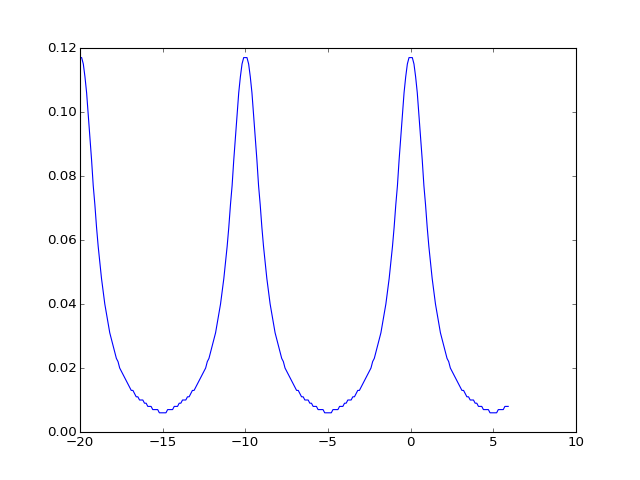

In [20]:
# plot (can also be done repeatedly while the sweep is running)
# next up: create an active plot that will update itself automatically
# (via javascript, so the main python stays accessible) as long as the sweep is running
# as well as provide some nicer styling and labeling defaults
swp.sync_live()
plt.plot(swp['chan0'], swp['amplitude'])

In [21]:
swp2 = measurement.sweep(c1[-15:15:1], 1, c0[-15:15:.5], 0.03, location='test2d')

<IPython.core.display.Javascript object>


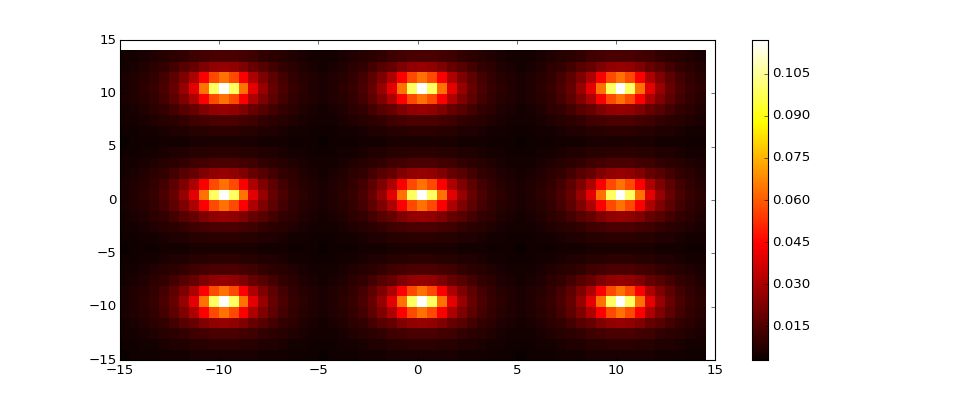

In [33]:
# again, can call this repeatedly while the plot is running
swp2.sync_live()
import numpy.ma as ma
plt.figure(figsize=(12,5))
# pcolormesh needs NaN masked out or it barfs
plt.pcolormesh(ma.masked_invalid(swp2['chan0']),
               ma.masked_invalid(swp2['chan1']),
               ma.masked_invalid(swp2['amplitude']),
               cmap=plt.cm.hot)
plt.colorbar()
plt.show()